# Background Removal using Mask R-CNN in PyTorch - Part 1: Core Implementation

This notebook demonstrates how to use Mask R-CNN to replace image backgrounds with black. The implementation is based on PyTorch and the Torchvision library.

## Dataset Overview
- Total number of images: 4,431
- Number of categories: 413
- Date range: 2025-02-17
- Image formats: JPEG, MPO
- Average dimensions: 1197x1308 pixels
- Average file size: 265.03 KB

## Data Quality Issues
- Missing values: 5,416 total across all columns
- Duplicate files: 0
- Date inconsistencies: 0
- Size outliers: 45
- Dimension outliers: 16

## 1. Setup and Import Libraries

In [1]:
# Install required packages if not already installed
!pip install torch torchvision matplotlib opencv-python tqdm

  Using cached torch-2.6.0-cp312-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (4.0 kB)
Using cached torch-2.6.0-cp312-none-macosx_11_0_arm64.whl (66.5 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached torchvision-0.21.0-cp312-cp312-macosx_11_0_arm64.whl (1.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 3.0 MB/s eta 0:00:0000:0100:01
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
Using cached filelock-3.17.0-py3-none-any.whl (16 kB)
Using cached networkx-

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from PIL import Image
from torchvision import transforms

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Load Mask R-CNN Model

In [2]:
# Load pre-trained Mask R-CNN model
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)
model.to(device)
model.eval()

# Get COCO class names
COCO_INSTANCE_CATEGORY_NAMES = weights.meta["categories"]
print(f"Model loaded with {len(COCO_INSTANCE_CATEGORY_NAMES)} classes")

Model loaded with 91 classes


## 3. Image Preprocessing and Prediction Functions

In [3]:
def load_image(img_path):
    """Load an image and convert to RGB"""
    try:
        img = Image.open(img_path).convert("RGB")
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

def preprocess_image(img):
    """Preprocess image for the model"""
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Apply transforms
    img_tensor = transform(img)
    return img_tensor

def get_prediction(img_tensor, threshold=0.5):
    """Get model prediction"""
    with torch.no_grad():
        prediction = model([img_tensor.to(device)])
        
    return prediction[0]

## 4. Background Removal Function

In [4]:
def remove_background(img_path, confidence_threshold=0.7, save_path=None):
    """Remove background from image using Mask R-CNN"""
    img = load_image(img_path)
    if img is None:
        return None, None
        
    img_tensor = preprocess_image(img)
    
    prediction = get_prediction(img_tensor)
    
    img_np = np.array(img)
    
    # Create a blank mask for the combined objects
    height, width = img_np.shape[:2]
    combined_mask = np.zeros((height, width), dtype=np.uint8)
    
    # Extract masks based on confidence score
    masks = prediction['masks']
    scores = prediction['scores']
    
    # Use a threshold to filter out low-confidence predictions
    high_confidence_masks = masks[scores > confidence_threshold]
    
    if len(high_confidence_masks) == 0:
        print(f"No objects detected with confidence threshold {confidence_threshold}")
        return img_np, combined_mask
    
    # Combine all high-confidence masks
    for mask_tensor in high_confidence_masks:
        mask = mask_tensor[0].cpu().numpy() > 0.5  # Convert to binary mask
        mask = mask.astype(np.uint8) * 255
        combined_mask = cv2.bitwise_or(combined_mask, mask)
    
    # Create a 3-channel mask for bitwise operations
    mask_3ch = cv2.merge([combined_mask, combined_mask, combined_mask])
    
    # Apply mask to keep foreground and make background black
    result = cv2.bitwise_and(img_np, mask_3ch)
    
    # Save result if path is provided
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    
    return result, combined_mask

## 5. Visualize Results

In [5]:
def visualize_results(original_img, processed_img, mask):
    """Visualize original image, mask, and processed image"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Segmentation Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Black Background Result')
    plt.imshow(processed_img)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## 6. Process a Single Image

Let's test our implementation on a single image

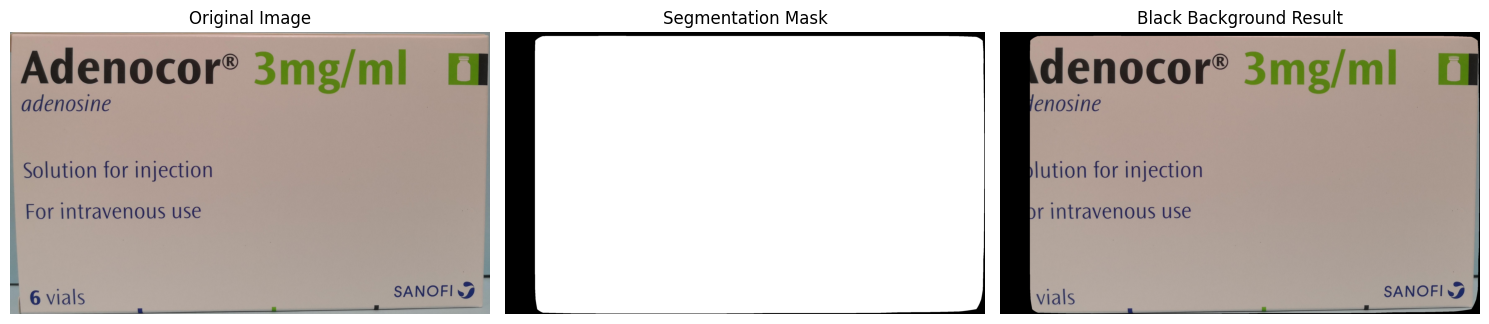

In [6]:
sample_img_path = "../data/Parenterals/Adenosine/Adenosine (Adenocor-Front Box) Inj 6mg in 2ml (MA_Sanofi, UK, mfr_Famar Health Care Services Mardrid S.A.U, Spain) v1 [23February2021]_0.jpg" 

if os.path.exists(sample_img_path):

    original_img = np.array(load_image(sample_img_path))
    
    processed_img, mask = remove_background(sample_img_path, confidence_threshold=0.3)
    
    visualize_results(original_img, processed_img, mask)
else:
    print(f"Image not found at {sample_img_path}. Please provide a valid image path.")

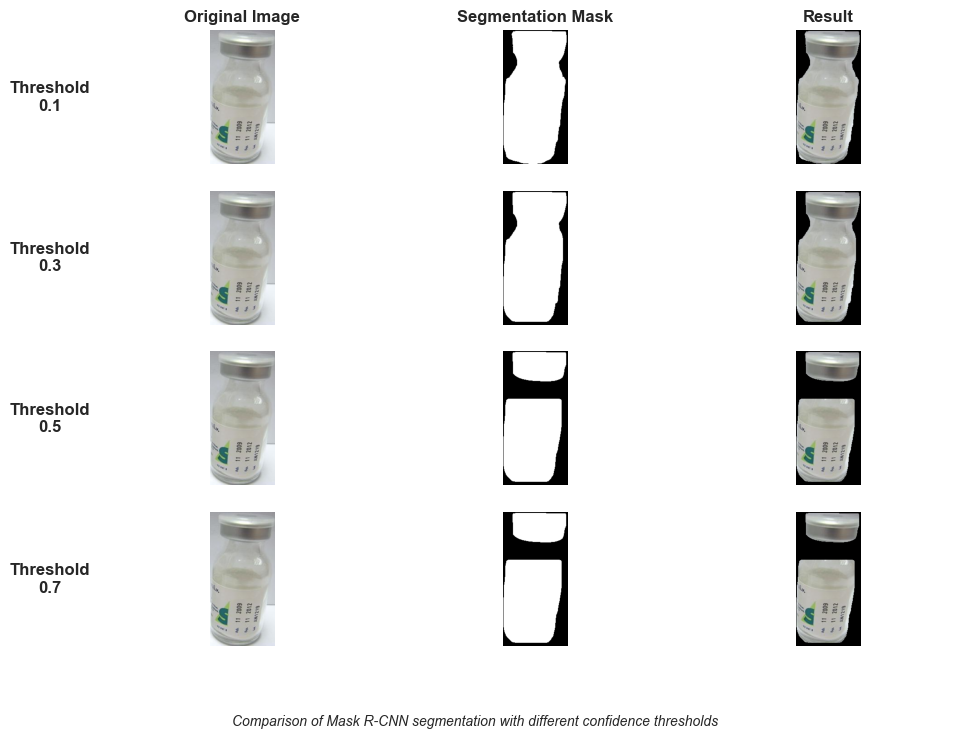

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.gridspec import GridSpec

def compare_thresholds(img_path, thresholds=[0.3, 0.5, 0.7]):
    """
    Compare different confidence thresholds for background removal in a grid.
    
    Args:
        img_path: Path to the input image
        thresholds: List of confidence thresholds to compare
    """
    if not os.path.exists(img_path):
        print(f"Image not found at {img_path}. Please provide a valid image path.")
        return
    
    original_img = np.array(load_image(img_path))
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(12, 8), constrained_layout=False)
    
    gs = GridSpec(len(thresholds), 4, figure=fig, width_ratios=[0.2, 1, 1, 1])
        
    col_titles = ['Original Image', 'Segmentation Mask', 'Result']
    for i, title in enumerate(col_titles):
        ax = fig.add_subplot(gs[0, i+1])
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
    
    for i, threshold in enumerate(thresholds):

        ax_label = fig.add_subplot(gs[i, 0])
        ax_label.text(0.5, 0.5, f'Threshold\n{threshold}', 
                      ha='center', va='center', fontsize=12, fontweight='bold')
        ax_label.axis('off')
        
        processed_img, mask = remove_background(img_path, confidence_threshold=threshold)
        
        ax1 = fig.add_subplot(gs[i, 1])
        ax1.imshow(original_img)
        ax1.axis('off')
        
        ax2 = fig.add_subplot(gs[i, 2])
        ax2.imshow(mask, cmap='gray')
        ax2.axis('off')
        
        ax3 = fig.add_subplot(gs[i, 3])
        ax3.imshow(processed_img)
        ax3.axis('off')
    
    plt.figtext(0.5, 0.01, 
                f"Comparison of Mask R-CNN segmentation with different confidence thresholds",
                ha="center", fontsize=10, fontstyle='italic')
    
    plt.savefig('threshold_comparison.png', dpi=120, bbox_inches='tight')
    plt.show()

sample_img_path = "../data/Parenterals/Cephazolin/Cephazolin (Sandoz) 1g Inj_0.jpg" 


# Compare different thresholds
compare_thresholds(sample_img_path, thresholds=[0.1, 0.3, 0.5, 0.7])

Starting processing of 8 files...
Processing file 1/8: Paracetamol (AFT Pharma - Front) Infusion 1g in 100ml (S.M. Farma, Italy) [31Jan2019]_0.jpg


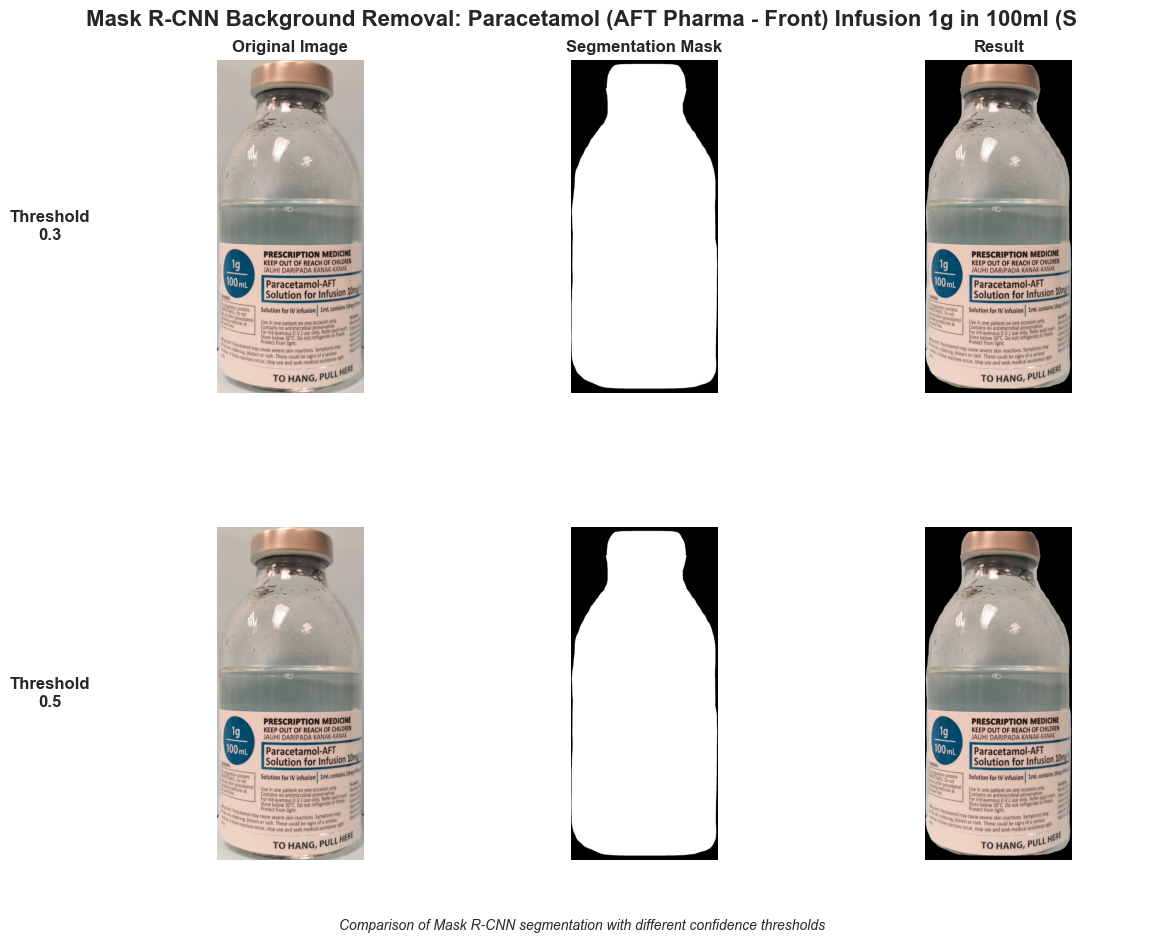

Processing file 2/8: Zoledronic acid (Aclasta) 5mg Infusion.jpg


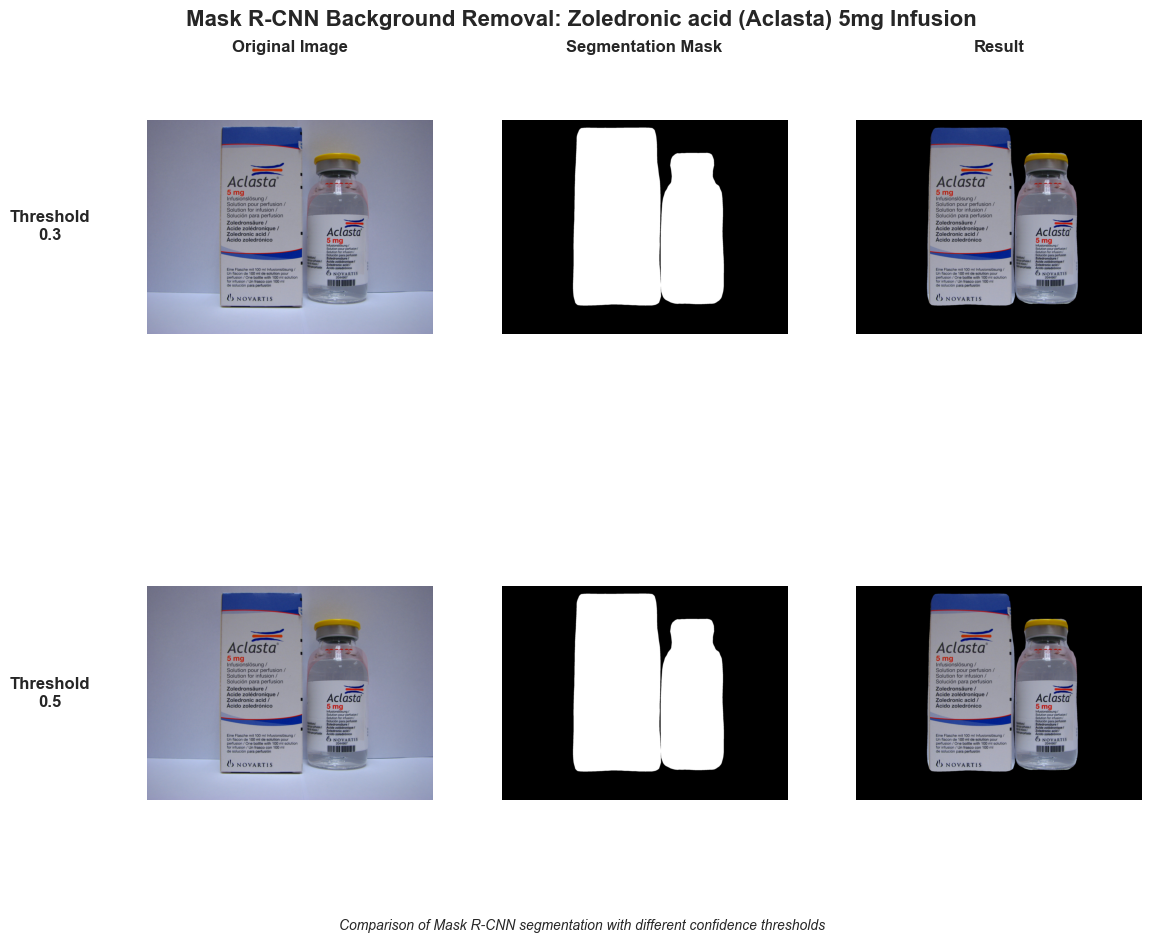

Processing file 3/8: Thyrotropine Releasing Hormone (TRH Ferring) Inj 200mcg per ml (PE)(MA&mfr_Ferring Arzneimittel GmbH, Germany) [27Sep2021].JPG


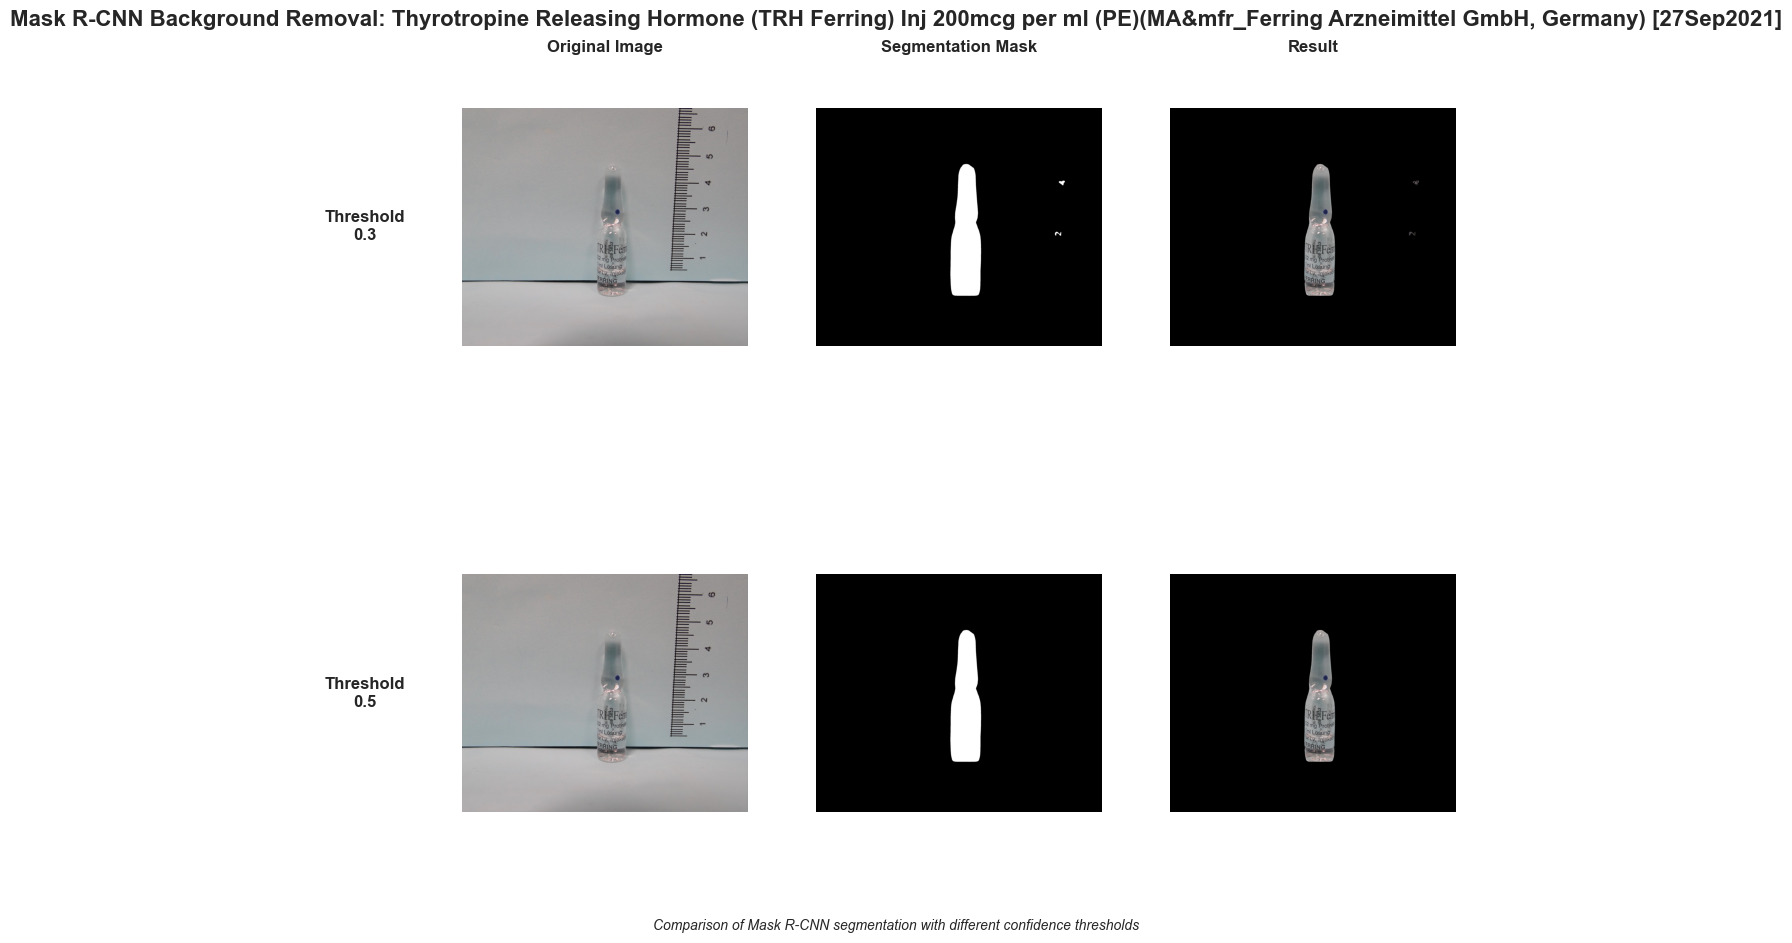

Processing file 4/8: Synthetic Oxytocin (Syntocinon) 10 units,ml.JPG


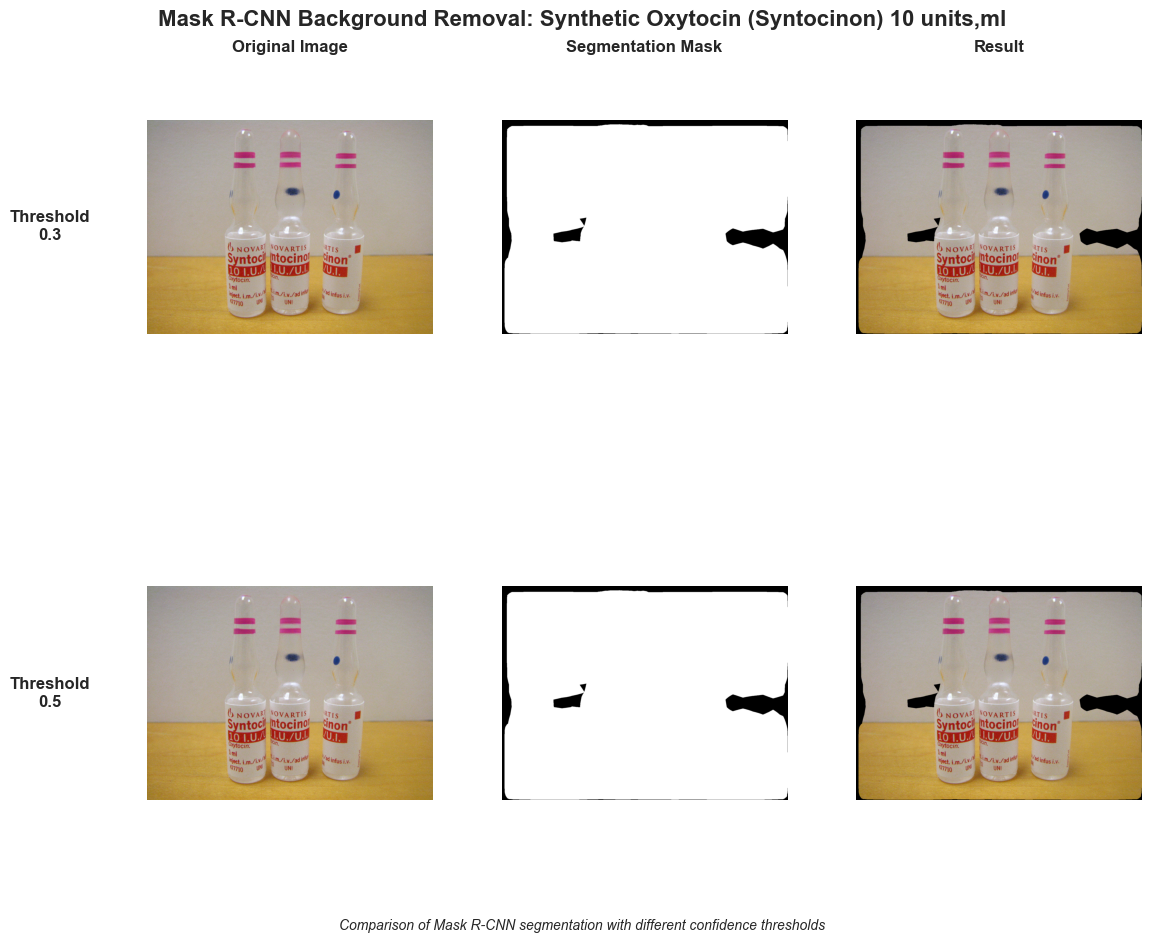

Processing file 5/8: Streptomycin (Meiji) 5g Inj.jpg


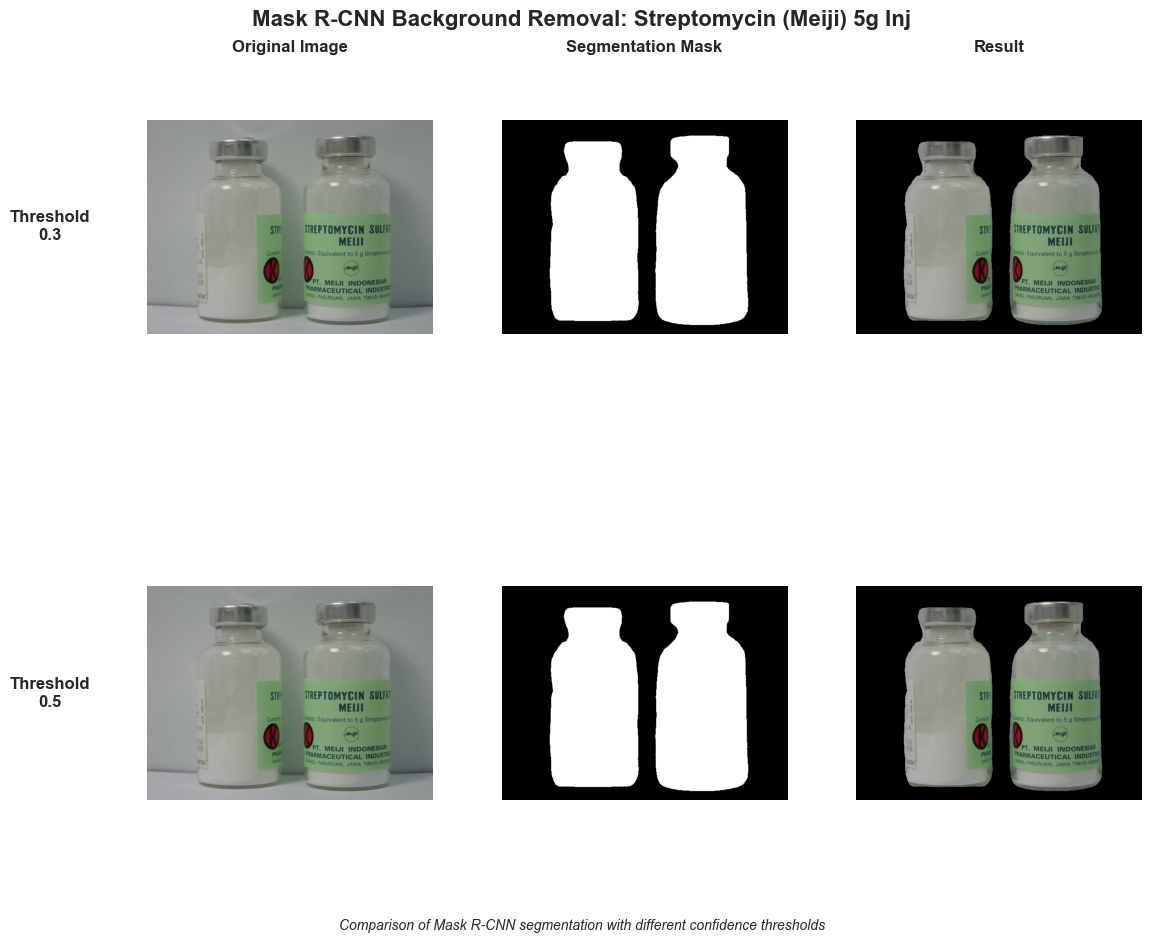

Processing file 6/8: MESNA (Uromitexan) 400mg,4ml v2_1.jpg


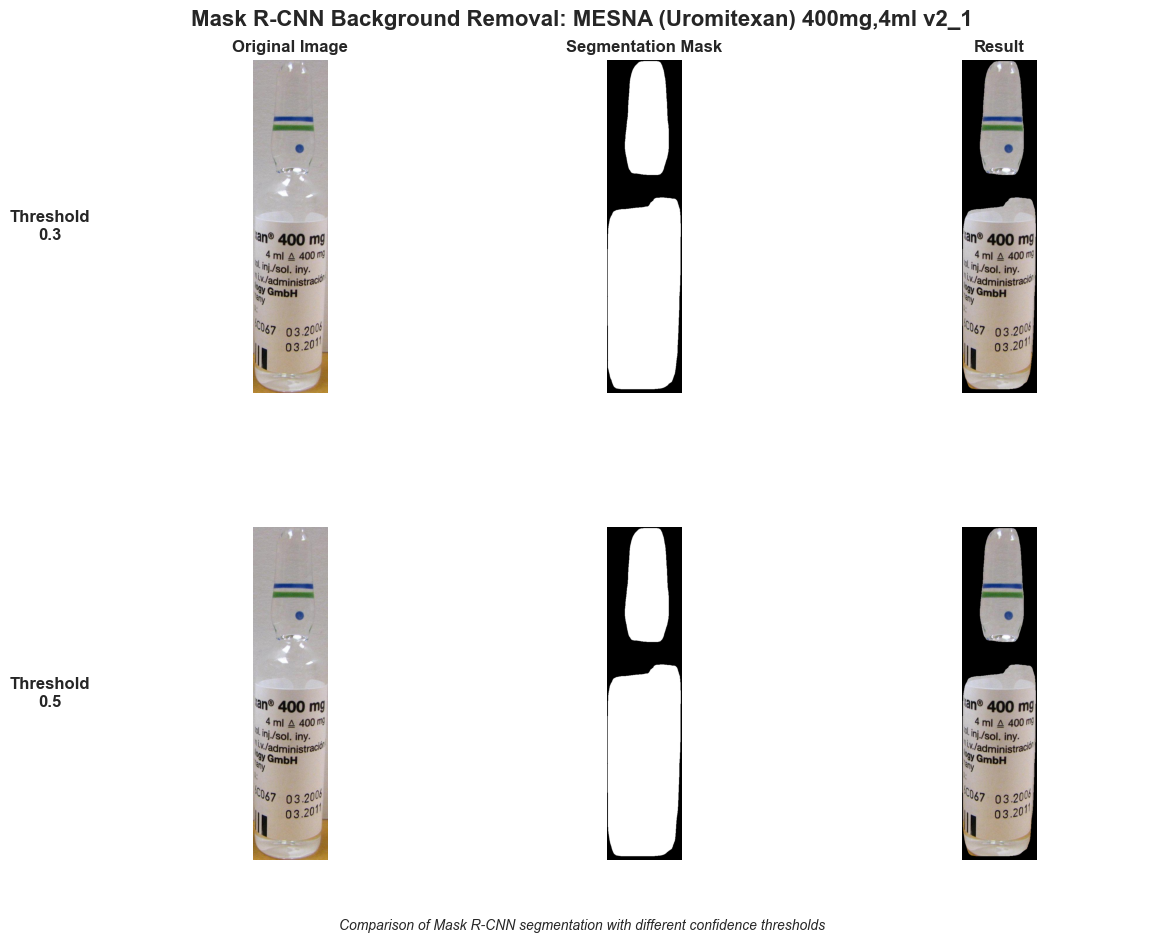

Processing file 7/8: Meningococcal ACWY Conjugate Vaccine (Nimenrix) [22Aug16]_0.jpg


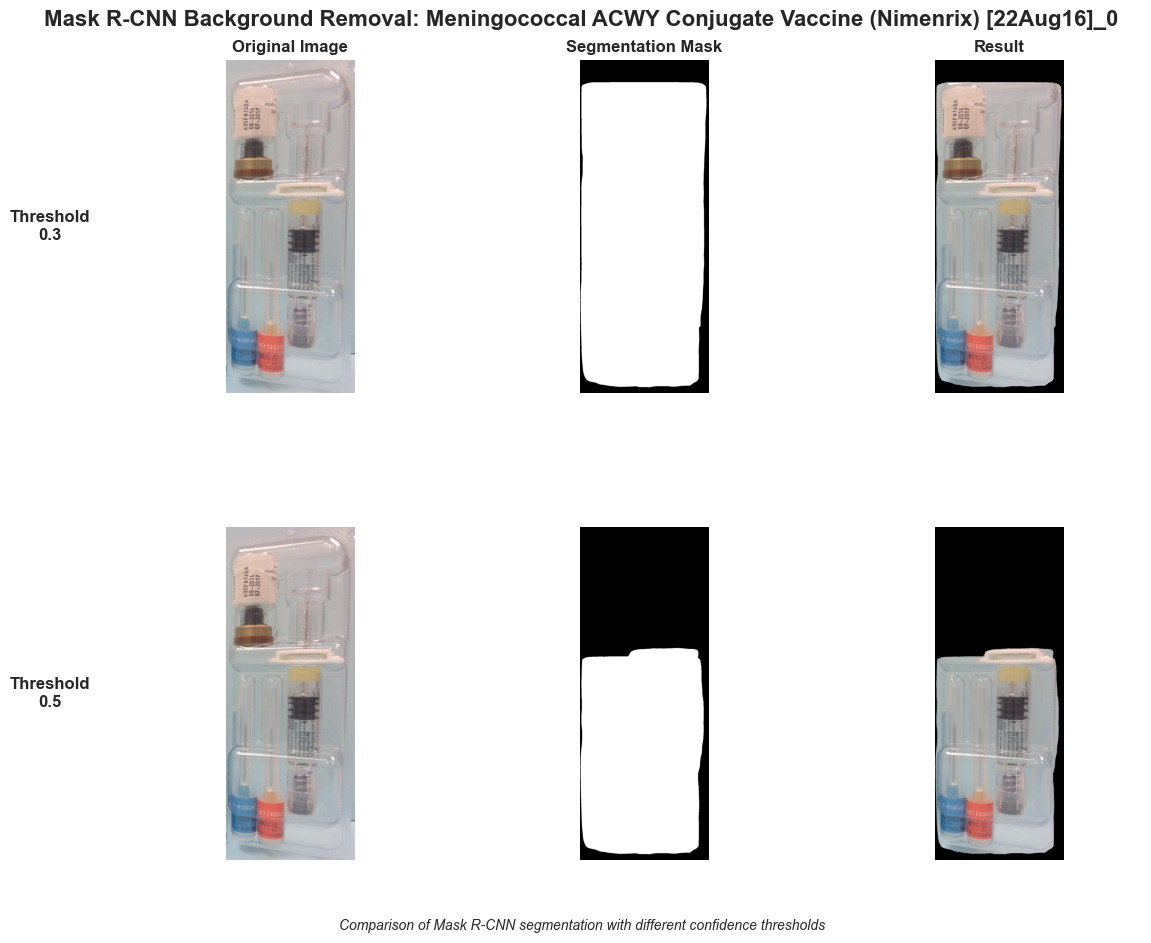

Processing file 8/8: Atropine Sulfate (Atlantic) Inj 600mcg, ml (Atlantic, Thailand) [26March2019]_0.jpg


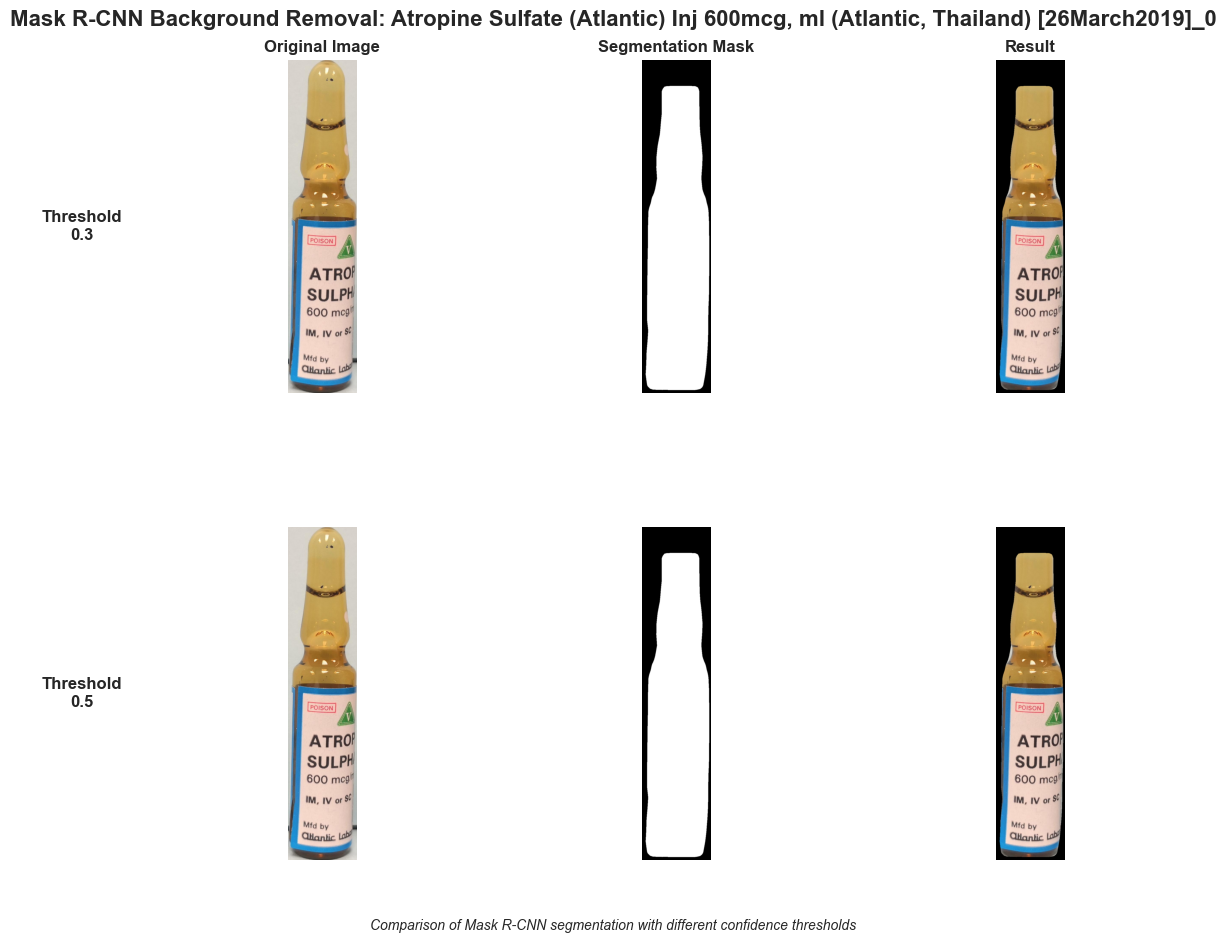

All files processed!


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.gridspec import GridSpec

def compare_thresholds(img_path, thresholds=[0.3, 0.5, 0.7]):
    """
    Compare different confidence thresholds for background removal in a grid.
    
    Args:
        img_path: Path to the input image
        thresholds: List of confidence thresholds to compare
    """
    if not os.path.exists(img_path):
        print(f"Image not found at {img_path}. Please provide a valid image path.")
        return
    
    img_name = os.path.basename(img_path).split('.')[0]
    
    original_img = np.array(load_image(img_path))
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(14, 10), constrained_layout=False)
    
    gs = GridSpec(len(thresholds), 4, figure=fig, 
                  width_ratios=[0.2, 1, 1, 1],
                  wspace=0.3, hspace=0.4)
    
    fig.suptitle(f'Mask R-CNN Background Removal: {img_name}', fontsize=16, fontweight='bold', y=0.95)
    
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    col_titles = ['Original Image', 'Segmentation Mask', 'Result']
    for i, title in enumerate(col_titles):
        ax = fig.add_subplot(gs[0, i+1])
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
    
    for i, threshold in enumerate(thresholds):
        # Add threshold label in first column
        ax_label = fig.add_subplot(gs[i, 0])
        ax_label.text(0.5, 0.5, f'Threshold\n{threshold}', 
                      ha='center', va='center', fontsize=12, fontweight='bold')
        ax_label.axis('off')
        
        # Process image with current threshold
        processed_img, mask = remove_background(img_path, confidence_threshold=threshold)
        
        # Display original image
        ax1 = fig.add_subplot(gs[i, 1])
        ax1.imshow(original_img)
        ax1.axis('off')
        
        # Display mask
        ax2 = fig.add_subplot(gs[i, 2])
        ax2.imshow(mask, cmap='gray')
        ax2.axis('off')
        
        # Display processed image
        ax3 = fig.add_subplot(gs[i, 3])
        ax3.imshow(processed_img)
        ax3.axis('off')
    
        # Add border around each subplot for better separation
        for j in range(1, 4):
            plt.subplot(gs[i, j])
            plt.box(on=True)
            plt.grid(False)
    
    plt.figtext(0.5, 0.03, 
                f"Comparison of Mask R-CNN segmentation with different confidence thresholds",
                ha="center", fontsize=10, fontstyle='italic')
    
    plt.show()

file_paths = [
    "../data/Parenterals/Paracetamol/Paracetamol (AFT Pharma - Front) Infusion 1g in 100ml (S.M. Farma, Italy) [31Jan2019]_0.jpg",
    "../data/Parenterals/Zoledronic/Zoledronic acid (Aclasta) 5mg Infusion.jpg",
    "../data/Parenterals/Thyrotropine/Thyrotropine Releasing Hormone (TRH Ferring) Inj 200mcg per ml (PE)(MA&mfr_Ferring Arzneimittel GmbH, Germany) [27Sep2021].JPG",
    "../data/Parenterals/Synthetic/Synthetic Oxytocin (Syntocinon) 10 units,ml.JPG"
]

print(f"Starting processing of {len(file_paths)} files...")
for i, file_path in enumerate(file_paths):
    print(f"Processing file {i+1}/{len(file_paths)}: {os.path.basename(file_path)}")
    compare_thresholds(file_path, thresholds=[0.3, 0.5])  # Using just two thresholds for efficiency

print("All files processed!")

# Process ALL Parenteral Images

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2
import torch
import torchvision
from torchvision.transforms import functional as F
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

# Load pre-trained Mask R-CNN model
def load_model():
    # Load a pre-trained Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()
    return model

# Global model instance
MODEL = None

def get_model():
    global MODEL
    if MODEL is None:
        MODEL = load_model()
    return MODEL

def preprocess_image(image):
    """Convert PIL image to tensor for model input."""
    # Convert to RGB if not already
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Convert to tensor and normalize
    img_tensor = F.to_tensor(image)
    
    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()
    
    return img_tensor

def get_prediction(img_tensor):
    """Get prediction from model."""
    model = get_model()
    with torch.no_grad():
        prediction = model(img_tensor)
    return prediction[0]  # Return first item in batch

def load_image(img_path):
    """Load and resize an image from path."""
    try:
        img = Image.open(img_path)
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

def remove_background(img_path, confidence_threshold=0.7, save_path=None):
    """Remove background from image using Mask R-CNN"""
    img = load_image(img_path)
    if img is None:
        return None, None
        
    img_tensor = preprocess_image(img)
    
    prediction = get_prediction(img_tensor)
    
    img_np = np.array(img)
    
    # Create a blank mask for the combined objects
    height, width = img_np.shape[:2]
    combined_mask = np.zeros((height, width), dtype=np.uint8)
    
    # Extract masks based on confidence score
    masks = prediction['masks']
    scores = prediction['scores']
    
    # Move tensors to CPU for numpy operations
    masks = masks.cpu()
    scores = scores.cpu()
    
    # Use a threshold to filter out low-confidence predictions
    high_confidence_indices = scores > confidence_threshold
    high_confidence_masks = masks[high_confidence_indices]
    
    if len(high_confidence_masks) == 0:
        # print(f"No objects detected with confidence threshold {confidence_threshold}")
        return img_np, combined_mask
    
    # Combine all high-confidence masks
    for mask_tensor in high_confidence_masks:
        mask = mask_tensor[0].numpy() > 0.5  # Convert to binary mask
        mask = mask.astype(np.uint8) * 255
        combined_mask = cv2.bitwise_or(combined_mask, mask)
    
    # Create a 3-channel mask for bitwise operations
    mask_3ch = cv2.merge([combined_mask, combined_mask, combined_mask])
    
    # Apply mask to keep foreground and make background black
    result = cv2.bitwise_and(img_np, mask_3ch)
    
    # Save result if path is provided
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    
    return result, combined_mask

def compare_thresholds(img_path, output_dir, thresholds=[0.3, 0.5, 0.7]):
    """
    Compare different confidence thresholds for background removal and save the result.
    
    Args:
        img_path: Path to the input image
        output_dir: Directory to save the output image
        thresholds: List of confidence thresholds to compare
    """
    if not os.path.exists(img_path):
        print(f"Image not found at {img_path}. Please provide a valid image path.")
        return False
    
    img_name = os.path.basename(img_path).split('.')[0]
    drug_folder = os.path.basename(os.path.dirname(img_path))
    
    # Load original image
    img = load_image(img_path)
    if img is None:
        return False
    
    original_img = np.array(img)
    
    # Create figure
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(14, 10), constrained_layout=False)
    
    gs = GridSpec(len(thresholds), 4, figure=fig, 
                  width_ratios=[0.2, 1, 1, 1],
                  wspace=0.3, hspace=0.4)
    
    fig.suptitle(f'{drug_folder}: {img_name}', fontsize=16, fontweight='bold', y=0.95)
    
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    
    col_titles = ['Original Image', 'Segmentation Mask', 'Result']
    for i, title in enumerate(col_titles):
        ax = fig.add_subplot(gs[0, i+1])
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
    
    for i, threshold in enumerate(thresholds):
        # Add threshold label in first column
        ax_label = fig.add_subplot(gs[i, 0])
        ax_label.text(0.5, 0.5, f'Threshold\n{threshold}', 
                      ha='center', va='center', fontsize=12, fontweight='bold')
        ax_label.axis('off')
        
        # Process image with current threshold
        processed_img, mask = remove_background(img_path, confidence_threshold=threshold)
        
        if processed_img is None:
            return False
        
        # Display original image
        ax1 = fig.add_subplot(gs[i, 1])
        ax1.imshow(original_img)
        ax1.axis('off')
        
        # Display mask
        ax2 = fig.add_subplot(gs[i, 2])
        ax2.imshow(mask, cmap='gray')
        ax2.axis('off')
        
        # Display processed image
        ax3 = fig.add_subplot(gs[i, 3])
        ax3.imshow(processed_img)
        ax3.axis('off')
    
        # Add border around each subplot for better separation
        for j in range(1, 4):
            plt.subplot(gs[i, j])
            plt.box(on=True)
            plt.grid(False)
    
    plt.figtext(0.5, 0.03, 
                f"Comparison of Mask R-CNN segmentation with different confidence thresholds",
                ha="center", fontsize=10, fontstyle='italic')
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create drug-specific subfolder
    drug_output_dir = os.path.join(output_dir, drug_folder)
    os.makedirs(drug_output_dir, exist_ok=True)
    
    # Save figure
    output_path = os.path.join(drug_output_dir, f"{img_name}_comparison.png")
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    
    return True

def find_all_images(base_dir):
    """Find all image files in the directory structure."""
    image_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.JPG', '.JPEG', '.PNG', '.TIF', '.TIFF']
    image_files = []
    
    for ext in image_extensions:
        # Using ** to search recursively through all subdirectories
        pattern = os.path.join(base_dir, "**", f"*{ext}")
        image_files.extend(glob.glob(pattern, recursive=True))
    
    return sorted(image_files)  # Sort for consistent processing order

def process_all_parenteral_images(base_dir="../data/Parenterals", output_dir="./processed_images", 
                                thresholds=[0.1, 0.3], limit=None, 
                                batch_report_freq=100):
    """
    Process all images in the Parenterals directory structure.
    
    Args:
        base_dir: Base directory for the Parenterals folder
        output_dir: Directory to save processed images
        thresholds: List of confidence thresholds to compare
        limit: Optional limit on the number of images to process
        batch_report_freq: Report progress every N images
    """
    print(f"Searching for images in {base_dir}...")
    image_files = find_all_images(base_dir)
    
    if limit:
        image_files = image_files[:limit]
    
    total_images = len(image_files)
    print(f"Found {total_images} images to process.")
    
    # Process each image
    successful = 0
    failed = 0
    
    # Create progress bar but without per-item updates
    # progress_bar = tqdm(total=total_images, desc="Processing images", 
    #                      bar_format='{l_bar}{bar:30}{r_bar}')
    
    for i, img_path in enumerate(image_files):
        # Only print updates at specified frequency
        if (i + 1) % batch_report_freq == 0 or i == 0 or i == total_images - 1:
            print(f"\nBatch update: Processed {i+1}/{total_images} images")
            print(f"Current success rate: {successful/(i+1)*100:.1f}%")
        
        # Extract the relative path from base_dir to use for organizing output
        try:
            if compare_thresholds(img_path, output_dir, thresholds):
                successful += 1
            else:
                failed += 1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            failed += 1
        
    #     # Update progress bar by 1
    #     progress_bar.update(1)
    
    # progress_bar.close()
    
    print(f"\nProcessing complete!")
    print(f"Successfully processed: {successful} images ({successful/total_images*100:.1f}%)")
    print(f"Failed to process: {failed} images ({failed/total_images*100:.1f}%)")
    print(f"Results saved to: {output_dir}")

if __name__ == "__main__":
    # Set the base directory to match your file structure
    base_dir = "../data/Parenterals"
    
    # Process all images with reduced output frequency
    process_all_parenteral_images(
        base_dir=base_dir,
        output_dir="./processed_parenteral_images",
        thresholds=[0.1],
        batch_report_freq=100  # Only show updates every 100 images
    )

Searching for images in ../data/Parenterals...
Found 4437 images to process.

Batch update: Processed 1/4437 images
Current success rate: 0.0%


/Users/marcus/Desktop/projects/AI Healthcare/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcus/Desktop/projects/AI Healthcare/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Batch update: Processed 100/4437 images
Current success rate: 99.0%


Processing images:  11%|███▏                          | 478/4437 [12:51<1:46:26,  1.61s/it]



Batch update: Processed 200/4437 images
Current success rate: 99.5%

Batch update: Processed 300/4437 images
Current success rate: 99.7%

Batch update: Processed 400/4437 images
Current success rate: 99.8%

Batch update: Processed 500/4437 images
Current success rate: 99.8%

Batch update: Processed 600/4437 images
Current success rate: 99.8%

Batch update: Processed 700/4437 images
Current success rate: 99.9%

Batch update: Processed 800/4437 images
Current success rate: 99.9%

Batch update: Processed 900/4437 images
Current success rate: 99.9%

Batch update: Processed 1000/4437 images
Current success rate: 99.9%

Batch update: Processed 1100/4437 images
Current success rate: 99.9%

Batch update: Processed 1200/4437 images
Current success rate: 99.9%

Batch update: Processed 1300/4437 images
Current success rate: 99.9%

Batch update: Processed 1400/4437 images
Current success rate: 99.9%

Batch update: Processed 1500/4437 images
Current success rate: 99.9%

Batch update: Processed 160

## 7. Advanced Post-Processing (Optional/Extra)

The basic Mask R-CNN segmentation might have imperfections at object boundaries. We can use GrabCut to refine the masks for better results.

In [17]:
def refine_mask_grabcut(img, mask, iterations=5):
    """Refine mask using GrabCut algorithm"""
    # Create a mask for GrabCut
    # 0: background, 1: foreground, 2: probable background, 3: probable foreground
    grabcut_mask = np.zeros(mask.shape, dtype=np.uint8)
    
    # Set mask values
    grabcut_mask[mask == 0] = 0  # Set definite background
    grabcut_mask[mask > 0] = 1    # Set definite foreground
    
    # Create background and foreground models
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    
    # Apply GrabCut
    rect = (0, 0, img.shape[1], img.shape[0])  # Full image rectangle
    cv2.grabCut(img, grabcut_mask, rect, bgdModel, fgdModel, iterations, cv2.GC_INIT_WITH_MASK)
    
    # Create mask where foreground and probable foreground pixels are 1
    refined_mask = np.where((grabcut_mask == 1) | (grabcut_mask == 3), 255, 0).astype('uint8')
    
    return refined_mask

In [18]:
def apply_refined_mask(img_path, confidence_threshold=0.7, use_grabcut=True, save_path=None):
    """Process image with optional refinement"""

    img = load_image(img_path)
    if img is None:
        return None, None
        
    img_np = np.array(img)
    
    processed_img, mask = remove_background(img_path, confidence_threshold)
    
    if use_grabcut and np.any(mask > 0):  # Only apply GrabCut if there's a mask
        refined_mask = refine_mask_grabcut(img_np, mask)
        
        # Create 3-channel mask
        mask_3ch = cv2.merge([refined_mask, refined_mask, refined_mask])
        
        # Apply refined mask
        refined_result = cv2.bitwise_and(img_np, mask_3ch)
        
        # Save result if path is provided
        if save_path:
            cv2.imwrite(save_path, cv2.cvtColor(refined_result, cv2.COLOR_RGB2BGR))
        
        return refined_result, refined_mask
    else:
        return processed_img, mask

In [19]:
def enhance_with_cap_detection(img_path, confidence_threshold=0.7, save_path=None):
    """
    Enhanced background removal with explicit cap detection
    """
    # Load and preprocess image
    img = load_image(img_path)
    if img is None:
        return None, None
        
    # Convert PIL image to numpy array for processing
    img_np = np.array(img)
    
    # Get standard mask using your existing method
    result, mask = remove_background(img_path, confidence_threshold)
    
    # Find the contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Get the largest contour (main bottle)
        main_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(main_contour)
        
        # Define cap region above the detected object
        cap_height = int(h * 0.15)  # Assume cap is about 15% of bottle height
        cap_region_y = max(0, y - cap_height)  # Look above the detected region
        
        # Create an extended mask including the cap region
        extended_mask = mask.copy()
        
        # Fill in the region above the bottle (where the cap likely is)
        extended_mask[cap_region_y:y, x:x+w] = 255
        
        # Create a 3-channel mask for bitwise operations
        mask_3ch = cv2.merge([extended_mask, extended_mask, extended_mask])
        
        # Apply mask to keep foreground and make background black
        enhanced_result = cv2.bitwise_and(img_np, mask_3ch)
        
        # Save result if path is provided
        if save_path:
            cv2.imwrite(save_path, cv2.cvtColor(enhanced_result, cv2.COLOR_RGB2BGR))
        
        return enhanced_result, extended_mask
    
    return result, mask

In [22]:
def compare_with_cap_enhancement(img_path, confidence_threshold=0.7):
    """Compare standard, GrabCut, and cap-enhanced background removal"""
    if not os.path.exists(img_path):
        print(f"Image not found at {img_path}")
        return
    
    original_img = np.array(load_image(img_path))
    
    basic_img, basic_mask = remove_background(img_path, confidence_threshold)
    
    grabcut_img, grabcut_mask = apply_refined_mask(img_path, confidence_threshold, use_grabcut=True)
    
    enhanced_img, enhanced_mask = enhance_with_cap_detection(img_path, confidence_threshold)
    
    # Visualize comparison
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.title('Basic Background Removal')
    plt.imshow(basic_img)
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.title('Refined (GrabCut)')
    plt.imshow(grabcut_img)
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.title('Cap-Enhanced Result')
    plt.imshow(enhanced_img)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

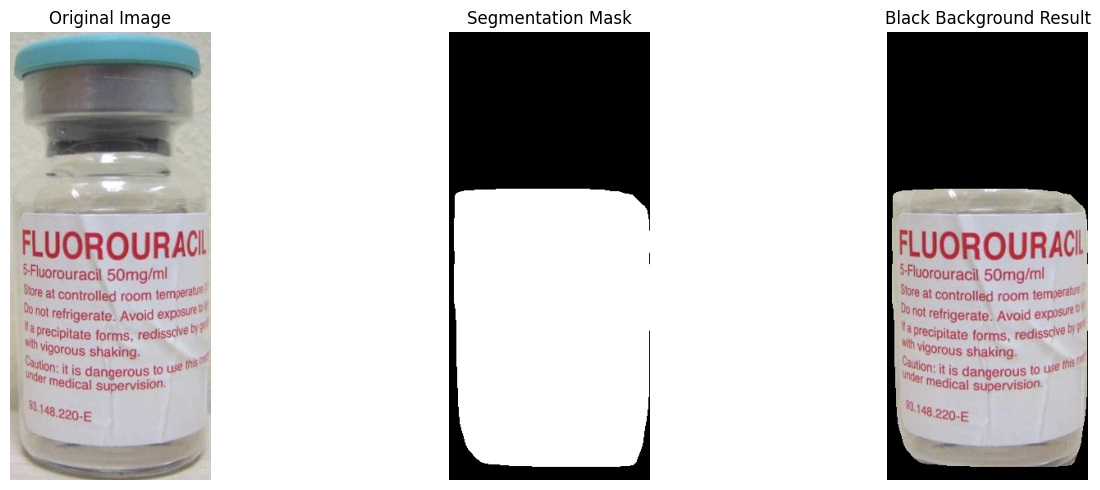

In [21]:
if os.path.exists(sample_img_path):

    original_img = np.array(load_image(sample_img_path))
    
    refined_img, refined_mask = apply_refined_mask(sample_img_path, confidence_threshold=0.7, use_grabcut=True)
    
    visualize_results(original_img, refined_img, refined_mask)
else:
    print(f"Image not found at {sample_img_path}. Please provide a valid image path.")

## 8. Comparing Results: Basic vs. Refined (Optional/Extra)

Let's compare the results of basic Mask R-CNN segmentation with the refined GrabCut version

In [12]:
def compare_results(img_path, confidence_threshold=0.7):
    """Compare basic and refined background removal"""
    if not os.path.exists(img_path):
        print(f"Image not found at {img_path}")
        return
    
    original_img = np.array(load_image(img_path))
    
    basic_img, basic_mask = remove_background(img_path, confidence_threshold)
    
    refined_img, refined_mask = apply_refined_mask(img_path, confidence_threshold, use_grabcut=True)
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.title('Basic Mask R-CNN Mask')
    plt.imshow(basic_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.title('Basic Background Removal')
    plt.imshow(basic_img)
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.title('Refined Background Removal (GrabCut)')
    plt.imshow(refined_img)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

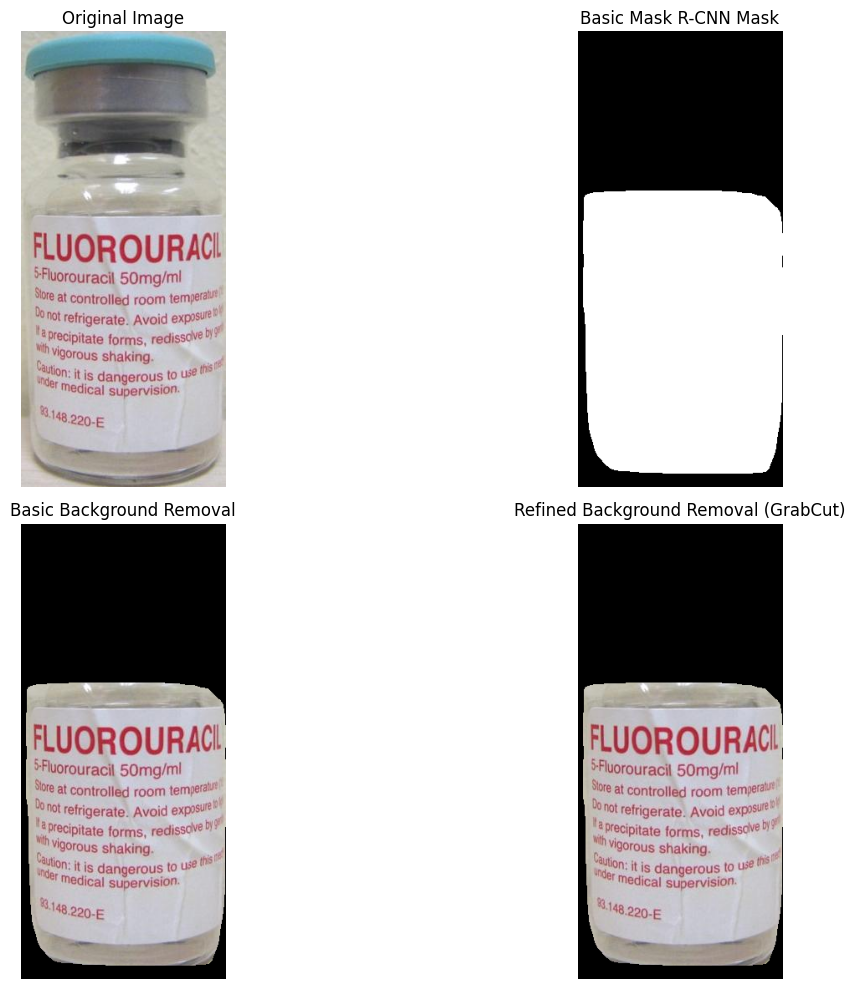

In [13]:
# Compare results if the sample image exists
if os.path.exists(sample_img_path):
    compare_results(sample_img_path, confidence_threshold=0.7)
else:
    print(f"Image not found at {sample_img_path}. Please provide a valid image path.")

## Next Steps: Architecture Modifications

- Use a model with higher resolution feature maps
- Consider using instance segmentation with multiple classes (bottle body and cap as separate classes)
- Implement boundary refinement modules to better capture object boundaries

In [27]:
def enhance_with_cap_detection(img_path, confidence_threshold=0.7, save_path=None):
    """
    Enhanced background removal with explicit cap detection (Approach 1)
    """
    # Load and preprocess image
    img = load_image(img_path)
    if img is None:
        return None, None
        
    # Convert PIL image to numpy array for processing
    img_np = np.array(img)
    
    # Get standard mask using your existing method
    result, mask = remove_background(img_path, confidence_threshold)
    
    # Find the contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Get the largest contour (main bottle)
        main_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(main_contour)
        
        # Define cap region above the detected object
        cap_height = int(h * 0.15)  # Assume cap is about 15% of bottle height
        cap_region_y = max(0, y - cap_height)  # Look above the detected region
        
        # Create an extended mask including the cap region
        extended_mask = mask.copy()
        
        # Fill in the region above the bottle (where the cap likely is)
        extended_mask[cap_region_y:y, x:x+w] = 255
        
        # Create a 3-channel mask for bitwise operations
        mask_3ch = cv2.merge([extended_mask, extended_mask, extended_mask])
        
        # Apply mask to keep foreground and make background black
        enhanced_result = cv2.bitwise_and(img_np, mask_3ch)
        
        # Save result if path is provided
        if save_path:
            cv2.imwrite(save_path, cv2.cvtColor(enhanced_result, cv2.COLOR_RGB2BGR))
        
        return enhanced_result, extended_mask
    
    return result, mask

def detect_and_include_cap(img_path, confidence_threshold=0.7, save_path=None):
    """
    Detect and include the bottle cap using color segmentation (Approach 2)
    """
    # Load and preprocess image
    img = load_image(img_path)
    if img is None:
        return None, None
        
    # Convert PIL image to numpy array for processing
    img_np = np.array(img)
    
    # Get standard mask using your existing method
    result, bottle_mask = remove_background(img_path, confidence_threshold)
    
    # Convert image to HSV for better color segmentation
    img_hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
    
    # Define HSV range for light blue cap
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    
    # Create color mask for the cap
    cap_mask = cv2.inRange(img_hsv, lower_blue, upper_blue)
    
    # Combine bottle mask and cap mask
    combined_mask = cv2.bitwise_or(bottle_mask, cap_mask)
    
    # Apply morphological closing to fill gaps between bottle and cap
    kernel = np.ones((5, 5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    
    # Create a 3-channel mask for bitwise operations
    mask_3ch = cv2.merge([combined_mask, combined_mask, combined_mask])
    
    # Apply mask to keep foreground and make background black
    enhanced_result = cv2.bitwise_and(img_np, mask_3ch)
    
    # Save result if path is provided
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(enhanced_result, cv2.COLOR_RGB2BGR))
    
    return enhanced_result, combined_mask

def boundary_expansion_solution(img_path, confidence_threshold=0.7, save_path=None):
    """
    Use boundary expansion to include caps in segmentation (Approach 3)
    """
    # Load and preprocess image
    img = load_image(img_path)
    if img is None:
        return None, None
        
    # Convert PIL image to numpy array for processing
    img_np = np.array(img)
    
    # Get standard mask using your existing method
    result, mask = remove_background(img_path, confidence_threshold)
    
    # Apply morphological dilation focused on the top region of detected objects
    height, width = mask.shape
    
    # Find contours to locate the objects
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a top-focused dilation mask
    top_mask = np.zeros_like(mask)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Focus on the top 20% of each object
        top_region_height = int(h * 0.2)
        top_region = mask[max(0, y-top_region_height):y+top_region_height, x:x+w]
        
        # Only process if the region is valid
        if top_region.size > 0:
            # Create a larger kernel for top expansion
            kernel = np.ones((15, 15), np.uint8)
            dilated_top = cv2.dilate(top_region, kernel, iterations=1)
            
            # Place the dilated top back
            top_mask[max(0, y-top_region_height):y+top_region_height, x:x+w] = dilated_top
    
    # Combine original mask with top-expanded mask
    enhanced_mask = cv2.bitwise_or(mask, top_mask)
    
    # Create a 3-channel mask for bitwise operations
    mask_3ch = cv2.merge([enhanced_mask, enhanced_mask, enhanced_mask])
    
    # Apply mask to keep foreground and make background black
    enhanced_result = cv2.bitwise_and(img_np, mask_3ch)
    
    # Save result if path is provided
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(enhanced_result, cv2.COLOR_RGB2BGR))
    
    return enhanced_result, enhanced_mask

def compare_all_approaches(img_path, confidence_threshold=0.7):
    """Compare all approaches for fixing the bottle cap segmentation"""
    if not os.path.exists(img_path):
        print(f"Image not found at {img_path}")
        return
    
    # Load original image
    original_img = np.array(load_image(img_path))
    
    # Basic Mask R-CNN processing
    basic_img, basic_mask = remove_background(img_path, confidence_threshold)
    
    # Approach 1: Region extension
    approach1_img, approach1_mask = enhance_with_cap_detection(img_path, confidence_threshold)
    
    # Approach 2: Color-based segmentation
    approach2_img, approach2_mask = detect_and_include_cap(img_path, confidence_threshold)
    
    # Approach 3: Boundary expansion
    approach3_img, approach3_mask = boundary_expansion_solution(img_path, confidence_threshold)
    
    # Visualize comparison
    plt.figure(figsize=(20, 15))
    
    # Original
    plt.subplot(3, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    # Basic Mask R-CNN
    plt.subplot(3, 3, 2)
    plt.title('Basic Mask R-CNN Result')
    plt.imshow(basic_img)
    plt.axis('off')
    
    # Basic Mask
    plt.subplot(3, 3, 3)
    plt.title('Basic Mask R-CNN Mask')
    plt.imshow(basic_mask, cmap='gray')
    plt.axis('off')
    
    # Approach 1: Region Extension
    plt.subplot(3, 3, 4)
    plt.title('Approach 1: Region Extension')
    plt.imshow(approach1_img)
    plt.axis('off')
    
    # Approach 1 Mask
    plt.subplot(3, 3, 5)
    plt.title('Approach 1: Region Extension Mask')
    plt.imshow(approach1_mask, cmap='gray')
    plt.axis('off')
    
    # Approach 2: Color-based
    plt.subplot(3, 3, 6)
    plt.title('Approach 2: Color-based')
    plt.imshow(approach2_img)
    plt.axis('off')
    
    # Approach 2 Mask
    plt.subplot(3, 3, 7)
    plt.title('Approach 2: Color-based Mask')
    plt.imshow(approach2_mask, cmap='gray')
    plt.axis('off')
    
    # Approach 3: Boundary Expansion
    plt.subplot(3, 3, 8)
    plt.title('Approach 3: Boundary Expansion')
    plt.imshow(approach3_img)
    plt.axis('off')
    
    # Approach 3 Mask
    plt.subplot(3, 3, 9)
    plt.title('Approach 3: Boundary Expansion Mask')
    plt.imshow(approach3_mask, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

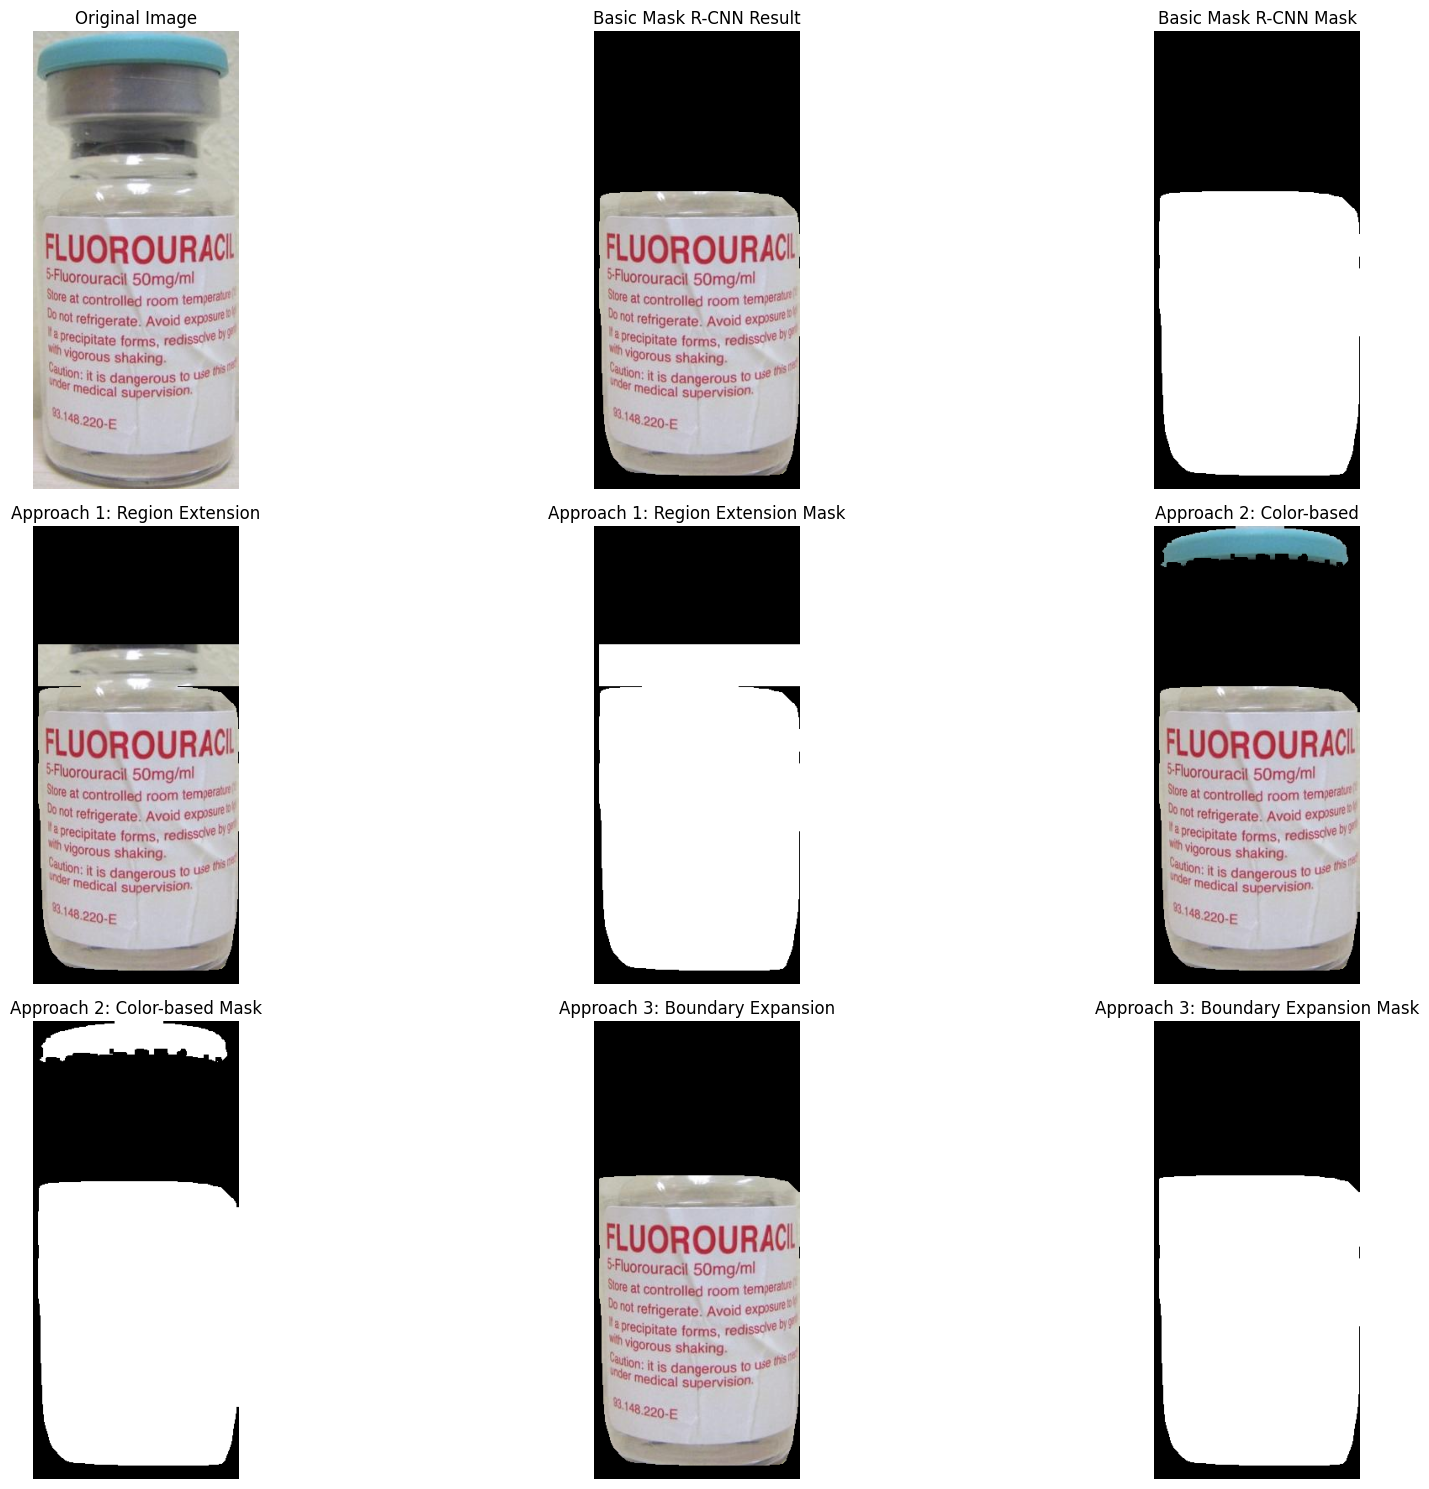

In [28]:
# Compare all approaches if the sample image exists
if os.path.exists(sample_img_path):
    compare_all_approaches(sample_img_path, confidence_threshold=0.7)
else:
    print(f"Image not found at {sample_img_path}. Please provide a valid image path.")

## 9. Conclusion and Next Steps

In this notebook, we've implemented basic and refined background removal using Mask R-CNN and GrabCut algorithms. The key components include:

1. Loading a pre-trained Mask R-CNN model
2. Processing images to detect objects and generate segmentation masks
3. Converting masks to binary format for background removal
4. Applying GrabCut refinement for improved edge quality
5. Visualizing and comparing the results

For batch processing and handling dataset quality issues, please refer to Part 2 of this notebook series.